# Estudio descriptivo: cruce con presiones

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Cargamos las librerías necesarias
from sklearn import preprocessing
from statistics import mode
import gower
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

/home/dslab/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
os.chdir('..')

In [5]:
# Cargamos las dos tablas de datos
perfiles = pd.read_parquet('data/raw/flex_perfiles_usuario.parquet')
sesiones = pd.read_parquet('data/raw/flex_sesiones.parquet')

In [6]:
# Filtro en perfiles valores erroneos peso y altura. Corrección formatos
perfiles.loc[perfiles["posicion"]=="manual","posicion"] = "Manual"

for col in ["altura", "peso"]:
    perfiles[col] = perfiles[col].str.replace(',', '.')

perfiles[["altura", "peso"]] = perfiles[["altura", "peso"]].apply(pd.to_numeric)

perfiles_filtrado = perfiles[(perfiles["peso"]<150) &
                             (perfiles["peso"]!=0 )& (perfiles["altura"]>100) & (perfiles["altura"]<220)]
# quitamos manual en sexo y, consecuentemente, en posicion
perfiles_filtrado = perfiles_filtrado[perfiles_filtrado["sexo"]!="Manual"] 
perfiles_filtrado.reset_index(drop=True, inplace=True)

# IMC
perfiles_filtrado['IMC'] = perfiles_filtrado['peso'] / (perfiles_filtrado['altura']/100)**2
perfiles_filtrado['IMC_cat'] = pd.cut(perfiles_filtrado['IMC'], bins=[0, 18.5, 24.9, 29.9, 50],
                                include_lowest=True,labels=['Bajo peso', 'Normal', 'Sobrepeso', 'Obesidad'])

## Cruce posición sexo

In [7]:
### Cruce posicion sexo
pd.crosstab(perfiles_filtrado["posicion"],perfiles_filtrado["sexo"])
# Los Manual de posicion son exactamente los Manual de sexo

sexo,Female,Male
posicion,,
Lateral,1754,1787
Supine,809,1277


¿Hay manera de saber qué es Manual en esas dos variables?

## Cruce presiones y sexo

In [8]:
### Cruce presiones y sexo
df_pres_sex = pd.DataFrame(pd.crosstab(perfiles_filtrado["presiones"],perfiles_filtrado["sexo"],normalize=False))
# Elimino aquellas presiones con menos de 10 registros en hombres o mujeres
df_pres_sex = df_pres_sex[(df_pres_sex["Female"]>=10) | (df_pres_sex["Male"]>=10)]
# Vemos las más frecuentes para cada uno
df_pres_sex_fem = df_pres_sex.sort_values(by=['Female'], ascending=False)
df_pres_sex_male = df_pres_sex.sort_values(by=['Male'], ascending=False)

In [9]:
df_pres_sex_fem.head()

sexo,Female,Male
presiones,,
112222222222,319,181
001122211222,267,0
002221112222,161,0
112222122222,147,1
002222112222,135,13


In [10]:
df_pres_sex_male.head()

sexo,Female,Male
presiones,,
112222322222,3,188
112222222222,319,181
112223222222,103,170
002233322222,0,142
002223211222,83,135


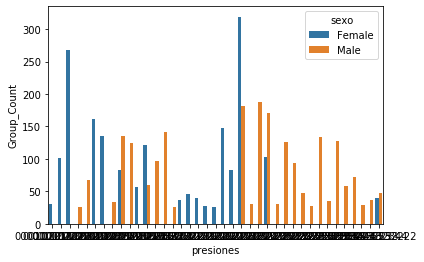

In [11]:
# Para pintarlo
grouped_df = perfiles_filtrado.groupby(["presiones","sexo"])
df_pres_sex_graph = pd.DataFrame(grouped_df.size().reset_index(name = "Group_Count"))
# Elimino aquellas presiones con menos de 20 registros en hombres o mujeres
df_pres_sex_graph = df_pres_sex_graph[df_pres_sex_graph["Group_Count"]>=25]
sns.barplot(y='Group_Count',x='presiones',hue='sexo',data=df_pres_sex_graph)
plt.show()

El gráfico no es muy visual pero permite ver las diferencias con respecto a presiones en hombres y mujeres

## Cruce presiones y posicion

In [12]:
### Cruce presiones y posicion
df_pres_pos = pd.DataFrame(pd.crosstab(perfiles_filtrado["presiones"],perfiles_filtrado["posicion"],normalize=False))
# Elimino aquellas presiones con menos de 10 registros en lateral o supine
df_pres_pos = df_pres_pos[(df_pres_pos["Lateral"]>=10) | (df_pres_pos["Supine"]>=10)]
# Vemos las más frecuentes para cada uno
df_pres_pos_lat = df_pres_pos.sort_values(by=['Lateral'], ascending=False)
df_pres_pos_sup = df_pres_pos.sort_values(by=['Supine'], ascending=False)

In [13]:
df_pres_pos_lat.head()

posicion,Lateral,Supine
presiones,,
001122211222,267,0
002223211222,218,0
002233211222,181,0
002221112222,161,0
002222112222,148,0


df_pres_pos_sup.head()

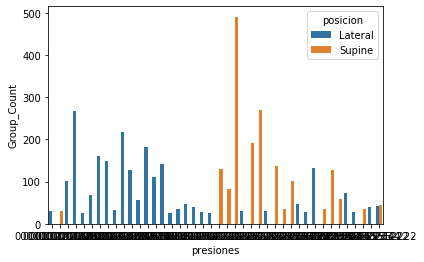

In [14]:
# Para pintarlo
grouped_df2 = perfiles_filtrado.groupby(["presiones","posicion"])
df_pres_pos_graph = pd.DataFrame(grouped_df2.size().reset_index(name = "Group_Count"))
# Elimino aquellas presiones con menos de 25 registros en hombres o mujeres
df_pres_pos_graph = df_pres_pos_graph[df_pres_pos_graph["Group_Count"]>=25]
sns.barplot(y='Group_Count',x='presiones',hue='posicion',data=df_pres_pos_graph)
plt.show()

La manera de dormir afecta totalmente a las presiones

## Cruce presiones y altura

In [15]:
### Cruce presiones y altura
# Categorizamos altura
perfiles_filtrado["altura_cat"] = pd.cut(perfiles_filtrado['altura'], bins=[0, 155, 170, 185, 250], include_lowest=True,
       labels=['<1.55', '1.55-1.7', '1.7-1.85', '>1.85'])
# Cruce
df_pres_alt = pd.DataFrame(pd.crosstab(perfiles_filtrado["presiones"],perfiles_filtrado["altura_cat"],normalize=False))



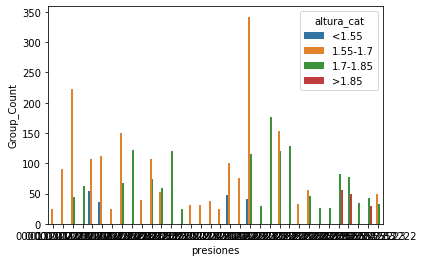

In [16]:
# Para pintarlo
grouped_df3 = perfiles_filtrado.groupby(["presiones","altura_cat"])
df_pres_alt_graph = pd.DataFrame(grouped_df3.size().reset_index(name = "Group_Count"))
# Elimino aquellas presiones con menos de 20 registros en hombres o mujeres
df_pres_alt_graph = df_pres_alt_graph[df_pres_alt_graph["Group_Count"]>=25]
sns.barplot(y='Group_Count',x='presiones',hue='altura_cat',data=df_pres_alt_graph)
plt.show()

# Mapas de calor para presiones

In [17]:
# Funcion previa
def presiones_df_heat(df):
    # Dado un df input, separar las presiones de la variable presiones de perfiles_usuario
    # df_pres: dataframe  de 12 columnas, una por cada posicion, 1 fila por id
    # df_completo_pres: join(df, df_pres)
    # df_pres_count: dataframe con 12 columnas (posiciones) y 6 filas (niveles de presion), conteo de valores
    # df_pres_prop: df_pres_count/total valores

    # Del df input nos quedamos con presiones
    df_pres = df['presiones']

    # Estructura para los df resultantes
    cols = ['PresPos1', 'PresPos2', 'PresPos3', 'PresPos4', 'PresPos5', 'PresPos6',
            'PresPos7', 'PresPos8', 'PresPos9', 'PresPos10', 'PresPos11', 'PresPos12']
    rows_heat = ['NivPres0', 'NivPres1', 'NivPres2', 'NivPres3', 'NivPres4', 'NivPres5']
    rows = range(len(df_pres))
    df_pres_split = pd.DataFrame(columns=cols, index=rows)
    df_pres_count = pd.DataFrame(columns=cols, index=rows_heat)

    # Separamos las presiones
    for j in range(len(df_pres)):
        pres_j = df_pres.iloc[j]
        pres_j_split = [pres_j[i:i + 1] for i in range(0, len(pres_j), 1)]
        df_pres_split.iloc[j, :] = pres_j_split

    # Para la distribucion
    k = 0
    for pos in cols:
        # print(pos)
        to_fill = list(df_pres_split.groupby(pos)[pos].size())
        if len(to_fill) != 6:
            to_fill = [sum(df_pres_split[pos] == '0'),sum(df_pres_split[pos] == '1'),
                       sum(df_pres_split[pos] == '2'),sum(df_pres_split[pos] == '3'),
                       sum(df_pres_split[pos] == '4'),sum(df_pres_split[pos] == '5')]
        df_pres_count.iloc[:, k] = to_fill
        k += 1

    # Dividimos df_pres_count por el total de observaciones para tener la proporcion
    df_pres_prop = df_pres_count / len(df_pres)
    # Juntamos las presiones separadas al df original
    df_completo_pres = pd.concat([df, df_pres_split], axis=1, join='inner')

    return df_completo_pres, df_pres_count, df_pres_prop

In [18]:
# Dataframes para cada grupo de interes
df_female = perfiles_filtrado[perfiles_filtrado['sexo'] == "Female"]
df_male = perfiles_filtrado[perfiles_filtrado['sexo'] == "Male"]
df_supine = perfiles_filtrado[perfiles_filtrado['posicion'] == "Supine"]
df_lateral = perfiles_filtrado[perfiles_filtrado['posicion'] == "Lateral"]
df_bajopeso = perfiles_filtrado[perfiles_filtrado['IMC_cat'] == "Bajo peso"]
df_normalpeso = perfiles_filtrado[perfiles_filtrado['IMC_cat'] == "Normal"]
df_sobrepeso = perfiles_filtrado[perfiles_filtrado['IMC_cat'] == "Sobrepeso"]
df_obesidad = perfiles_filtrado[perfiles_filtrado['IMC_cat'] == "Obesidad"]

# Obtenemos info presiones
_, _, df_female_heat = presiones_df_heat(df_female)
_, _, df_male_heat = presiones_df_heat(df_male)

_, _, df_supine_heat = presiones_df_heat(df_supine)
_, _, df_lateral_heat = presiones_df_heat(df_lateral)

_, _, df_bajopeso_heat = presiones_df_heat(df_bajopeso)
_, _, df_normalpeso_heat = presiones_df_heat(df_normalpeso)
_, _, df_sobrepeso_heat = presiones_df_heat(df_sobrepeso)
_, _, df_obesidad_heat = presiones_df_heat(df_obesidad)

In [24]:
### Mapa de calor general a modo de ejemplo
_, _, perfiles_filtrado_heat = presiones_df_heat(perfiles_filtrado)

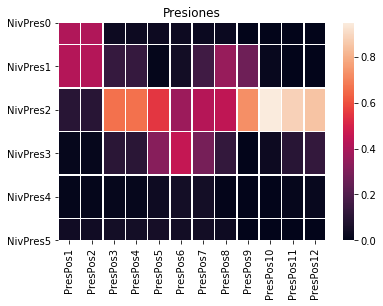

In [25]:

sns.heatmap(perfiles_filtrado_heat, linewidth=0.5).set_title('Presiones')
plt.show()

### Mapa calor presiones en sexo

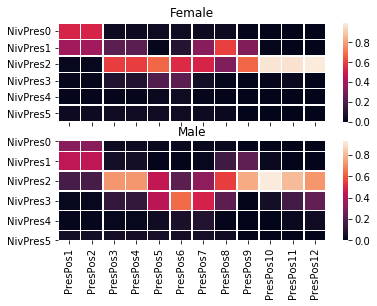

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True)
sns.heatmap(df_female_heat, linewidth=0.5, ax = ax1).set_title('Female')
sns.heatmap(df_male_heat, linewidth=0.5, ax = ax2).set_title('Male')
plt.show()

### Mapa calor presiones en posición

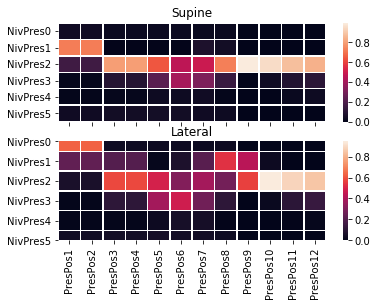

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True)
sns.heatmap(df_supine_heat, linewidth=0.5, ax = ax1).set_title('Supine')
sns.heatmap(df_lateral_heat, linewidth=0.5, ax = ax2).set_title('Lateral')
plt.show()

### Mapa calor presiones en IMC

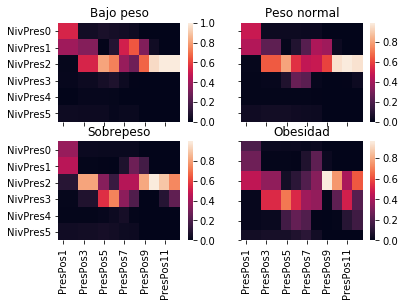

In [21]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
sns.heatmap(df_bajopeso_heat, ax=axs[0, 0]).set_title('Bajo peso')
sns.heatmap(df_normalpeso_heat, ax=axs[0, 1]).set_title('Peso normal')
sns.heatmap(df_sobrepeso_heat, ax=axs[1, 0]).set_title('Sobrepeso')
sns.heatmap(df_obesidad_heat, ax=axs[1, 1]).set_title('Obesidad')
plt.show()


### Ejemplos

#### Presiones en hombres grandes con posición Supine y en mujeres pequeñas con posición Lateral

In [22]:
cat_bigmen = perfiles_filtrado[(perfiles_filtrado["sexo"]=="Male") & (perfiles_filtrado["posicion"] == "Supine") 
                               & (perfiles_filtrado["altura"]>=180) & (perfiles_filtrado["peso"] >= 80)]
cat_smallwomen = perfiles_filtrado[(perfiles_filtrado["sexo"]=="Female") & (perfiles_filtrado["posicion"] == "Lateral")
                                   & (perfiles_filtrado["altura"]<=160) & (perfiles_filtrado["peso"] <= 60)]
# Cambiamos la posicion
cat_bigmen2 = perfiles_filtrado[(perfiles_filtrado["sexo"]=="Male") & (perfiles_filtrado["posicion"] == "Lateral") 
                               & (perfiles_filtrado["altura"]>=180) & (perfiles_filtrado["peso"] >= 80)]
cat_smallwomen2 = perfiles_filtrado[(perfiles_filtrado["sexo"]=="Female") & (perfiles_filtrado["posicion"] == "Supine")
                                   & (perfiles_filtrado["altura"]<=160) & (perfiles_filtrado["peso"] <= 60)]

# Obtenemos mapas de calor
_,_, df_pres_prop_bigmen = presiones_df_heat(cat_bigmen)
_,_, df_pres_prop_smallwomen = presiones_df_heat(cat_smallwomen)
_,_, df_pres_prop_bigmen2 = presiones_df_heat(cat_bigmen2)
_,_, df_pres_prop_smallwomen2 = presiones_df_heat(cat_smallwomen2)

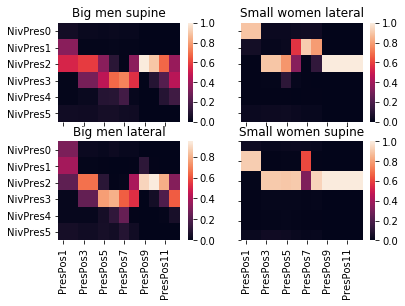

In [23]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
sns.heatmap(df_pres_prop_bigmen, ax=axs[0, 0]).set_title('Big men supine')
sns.heatmap(df_pres_prop_smallwomen, ax=axs[0, 1]).set_title('Small women lateral')
sns.heatmap(df_pres_prop_bigmen2, ax=axs[1, 0]).set_title('Big men lateral')
sns.heatmap(df_pres_prop_smallwomen2, ax=axs[1, 1]).set_title('Small women supine')
plt.show()

In [26]:
sesiones = pd.read_parquet('data/raw/flex_sesiones.parquet')

In [27]:
sesiones["sqr"].describe()


count     73224.000000
mean        996.445176
std        6340.056657
min        -381.812000
25%          29.547875
50%          54.576650
75%         536.534000
max      540000.000000
Name: sqr, dtype: float64